In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count, split,log


In [2]:
spark = SparkSession.builder.appName("AirBnB").getOrCreate()

In [ ]:
# df = spark.read.csv("C:/Users/ankus/Downloads/kgarrett-inside-airbnb-london/kgarrett-inside-airbnb-london/listings.csv",\
#                     header = True, inferSchema= True)

In [3]:
# read the file while keeping the header as it is
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiline", "true")\
    .option('escape', "\"")\
    .load("C:/Users/ankus/Downloads/kgarrett-inside-airbnb-london/kgarrett-inside-airbnb-london/listings.csv")

In [4]:
df.show(3)

+-----+--------------------+-------+---------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|   id|                name|host_id|host_name|neighbourhood_group|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+-----+--------------------+-------+---------+-------------------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|13913|Holiday London DB...|  54730|    Alina|               null|           Islington|51.56802| -0.11121|   Private room|   65|             1|               16| 2019-06-10|             0.15|                             3|             347|
|15400|Bright Chelsea  A...|  60302| Phi

In [5]:
df.count()

83850

In [6]:
# count no of unique id
df.select(["id"]).distinct().count()

83850

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)



In [8]:
#df.select([count(when(isnan(c) | col(c).isnull())) for c in df.columns]).show()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)


-RECORD 0-------------------------------
 id                             | 0     
 name                           | 26    
 host_id                        | 0     
 host_name                      | 47    
 neighbourhood_group            | 83850 
 neighbourhood                  | 0     
 latitude                       | 0     
 longitude                      | 0     
 room_type                      | 0     
 price                          | 0     
 minimum_nights                 | 0     
 number_of_reviews              | 0     
 last_review                    | 21023 
 reviews_per_month              | 21023 
 calculated_host_listings_count | 0     
 availability_365               | 0     



In [9]:
df.filter(df.host_id.isNull())

# 314066,"North London(double private room)
#Zone 3",1613803,Talat And Nalan,,Haringey,51.60139,-0.08639,Private room,26,1,264,2019-07-10,2.99,3,326

#so have to use multiline=True option to resolve this

DataFrame[id: string, name: string, host_id: string, host_name: string, neighbourhood_group: string, neighbourhood: string, latitude: string, longitude: string, room_type: string, price: string, minimum_nights: string, number_of_reviews: string, last_review: string, reviews_per_month: string, calculated_host_listings_count: string, availability_365: string]

In [10]:
df_missingReviews = df.filter(df.reviews_per_month.isNull())
df_missingReviews.select("number_of_reviews").distinct().show()

+-----------------+
|number_of_reviews|
+-----------------+
|                0|
+-----------------+



In [11]:
# drop col for host_name as not useful for analysis, also neighbpurhood_group has lot of missing value so not useful
df2= df.drop("name","host_name","neighbourhood_group")
df2.printSchema()

root
 |-- id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)



In [12]:
from pyspark.sql.functions import to_date, lit,datediff
from pyspark.sql import functions as F

In [13]:
#convert to correct data type
df_date_features = df2.withColumn("last_review_date", to_date(df2.last_review))
df_date_features = df_date_features.withColumn("Availability_365",df_date_features.availability_365.cast("int"))
df_date_features = df_date_features.withColumn("host_listings_count",df_date_features.calculated_host_listings_count.cast("int"))
df_date_features = df_date_features.withColumn("reviews_per_month",df_date_features.reviews_per_month.cast("double"))

df_date_features = df_date_features.withColumn("number_of_reviews",df_date_features.number_of_reviews.cast("int"))
df_date_features = df_date_features.withColumn("minimum_nights",df_date_features.minimum_nights.cast("int"))
df_date_features = df_date_features.withColumn("price",df_date_features.price.cast("double"))
df_date_features = df_date_features.drop("last_review")

In [ ]:
df_date_features.printSchema()

In [14]:
df_dummy = df_date_features.drop("last_review_date")
df_dummy.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_dummy.columns]).show(vertical=True)


-RECORD 0-------------------------------
 id                             | 0     
 host_id                        | 0     
 neighbourhood                  | 0     
 latitude                       | 0     
 longitude                      | 0     
 room_type                      | 0     
 price                          | 0     
 minimum_nights                 | 0     
 number_of_reviews              | 0     
 reviews_per_month              | 21023 
 calculated_host_listings_count | 0     
 Availability_365               | 0     
 host_listings_count            | 0     



In [ ]:
df_date_features.show(2)

In [15]:
df_date_features.select(F.min('number_of_reviews')).show()


+----------------------+
|min(number_of_reviews)|
+----------------------+
|                     0|
+----------------------+



In [16]:
#df_date_features.select(max("last_review_date"))
df_date_features.select(F.min('last_review_date')).show()
df_date_features.select(F.max('last_review_date')).show()


+---------------------+
|min(last_review_date)|
+---------------------+
|           2011-07-02|
+---------------------+

+---------------------+
|max(last_review_date)|
+---------------------+
|           2019-07-11|
+---------------------+



In [18]:
# We will fill missing values with date lesser then the first available date, so that reviews are considered before the study time
df_date_features = df_date_features.withColumn('last_review_date',when(col('last_review_date').isNull(),\
                                                to_date(lit('2011-01-01'),'yyyy-MM-dd')).otherwise(col('last_review_date')))

df_date_features = df_date_features.withColumn('reviews_per_month',when(col('reviews_per_month').isNull(),\
                                                0).otherwise(col('reviews_per_month')))


In [19]:
df_date_features.select(F.min('last_review_date')).show()
df_date_features.select(F.max('last_review_date')).show()

+---------------------+
|min(last_review_date)|
+---------------------+
|           2011-01-01|
+---------------------+

+---------------------+
|max(last_review_date)|
+---------------------+
|           2019-07-11|
+---------------------+



In [20]:
df_dummy = df_date_features.drop("last_review_date")
df_dummy.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_dummy.columns]).show(vertical=True)


-RECORD 0-----------------------------
 id                             | 0   
 host_id                        | 0   
 neighbourhood                  | 0   
 latitude                       | 0   
 longitude                      | 0   
 room_type                      | 0   
 price                          | 0   
 minimum_nights                 | 0   
 number_of_reviews              | 0   
 reviews_per_month              | 0   
 calculated_host_listings_count | 0   
 Availability_365               | 0   
 host_listings_count            | 0   



In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [ ]:
from geopy.geocoders import Nominatim
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# create a geocoder instance

# define a UDF to convert lat, long to city and state
def reverse_geocode(lat, long):
    geolocator = Nominatim(user_agent="geoapiExercisesweer")

    location = geolocator.reverse(f"{lat}, {long}")
    if location:
        address = location.raw['address']
        city = address['city']
        state = address['state']
        postcode = address['postcode']
        return f"{city}, {postcode}, {state}"
    return None


# register the UDF

In [ ]:
reverse_geocode_udf = udf(reverse_geocode, StringType())

# apply the UDF to the dataframe
df_date_features = df_date_features.withColumn("city_state_postcode", reverse_geocode_udf("latitude", "longitude"))
df_date_features.show(2)

In [ ]:
df_date_features.cache()

In [ ]:
df_date_features = df_date_features.withColumn("City", split(df_date_features["city_state_postcode"],",").getItem(0)) \
                                   .withColumn("Postcode", split(df_date_features["city_state_postcode"],",").getItem(1))\
                                    .withColumn("State", split(df_date_features["city_state_postcode"],",").getItem(2))
df_date_features.show(2)

In [21]:
from pyspark.sql.functions import dayofmonth, hour, dayofyear, month, weekofyear, date_format

In [22]:
# Take the days since last review
df_date_features = df_date_features.withColumn("DaysSinceLastReview", datediff(col("last_review_date"), \
                                                                               to_date(lit('2011-01-01'),'yyyy-MM-dd')))
df_date_features.show(2)

+-----+-------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+
|   id|host_id|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|Availability_365|last_review_date|host_listings_count|DaysSinceLastReview|
+-----+-------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+
|13913|  54730|           Islington|51.56802| -0.11121|   Private room| 65.0|             1|               16|             0.15|                             3|             347|      2019-06-10|                  3|               3082|
|15400|  60302|Kensington and Ch...|51.48796| -0.16898|Entire ho

In [23]:
df_reviews = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiline", "true")\
    .load("C:/Users/ankus/Downloads/kgarrett-inside-airbnb-london/kgarrett-inside-airbnb-london/reviews.csv")

In [24]:
df_reviews.show(2)

+----------+----------+
|listing_id|      date|
+----------+----------+
|     13913|2010-08-18|
|     13913|2011-07-11|
+----------+----------+
only showing top 2 rows



In [25]:
df_reviews.count()

1382210

In [26]:
df_reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- date: string (nullable = true)



In [27]:
df_reviews = df_reviews.withColumn("ReviewDate", to_date(col("date"),"yyyy-MM-dd"))
df_reviews = df_reviews.withColumn("ReviewMonth", month(col("ReviewDate")))

df_reviews.show(2)

+----------+----------+----------+-----------+
|listing_id|      date|ReviewDate|ReviewMonth|
+----------+----------+----------+-----------+
|     13913|2010-08-18|2010-08-18|          8|
|     13913|2011-07-11|2011-07-11|          7|
+----------+----------+----------+-----------+
only showing top 2 rows



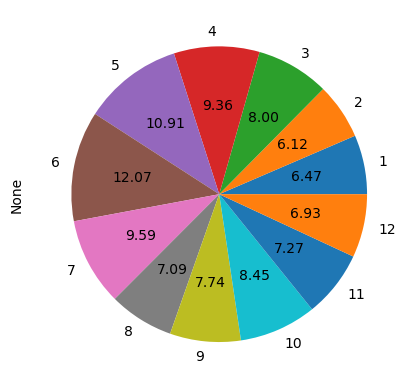

In [28]:
temp = df_reviews.toPandas()
temp.groupby('ReviewMonth').size().plot(kind='pie', autopct='%.2f');

In [29]:
pivotDF = df_reviews.groupBy("listing_id").pivot("ReviewMonth").count()

pivotDF=pivotDF.na.fill(value=0)

pivotDF.show(2)

+----------+---+---+---+---+---+---+---+---+---+---+---+---+
|listing_id|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12|
+----------+---+---+---+---+---+---+---+---+---+---+---+---+
|   3294255|  5|  5|  3| 10| 14| 20| 26| 14| 15| 20|  9|  7|
|  29427917|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  2|  1|
+----------+---+---+---+---+---+---+---+---+---+---+---+---+
only showing top 2 rows



In [30]:
pivotDF.count()
# we can see that many hotels have not got any reviews

62826

In [31]:
pivotDF.select(["listing_id"]).distinct().count()

62826

In [32]:
# merge reviews per month with listing dataframe
df_merge = df_date_features.join(pivotDF, df_date_features.id == pivotDF.listing_id, "left")
print(df_merge.count())
df_merge.show(2)

83850
+-----+-------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+
|   id|host_id|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|Availability_365|last_review_date|host_listings_count|DaysSinceLastReview|listing_id|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12|
+-----+-------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+
|13913|  54730|           Islington|51.56802| -0.11121|   Private room| 65.0|             1|               16|     

In [33]:
# we will remove identifiers from dataset
df_merge2 = df_merge.drop("host_id","last_review_date", "listing_id")

In [128]:
df_postcode = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiline", "true")\
    .load("C:/Users/ankus/Downloads/kgarrett-inside-airbnb-london/kgarrett-inside-airbnb-london/df_postcode.csv")

In [129]:
df_merge3 = df_merge2.join(df_postcode, df_postcode.id == df_merge2.id, "left")
print(df_merge3.count())
df_merge3.show(2)

83850
+-----+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+-------------------+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+--------+-------------------------+
|   id|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|Availability_365|host_listings_count|DaysSinceLastReview|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12|_c0|   id|Postcode|OtherPropertiesinPostcode|
+-----+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+-------------------+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+--------+-------------------------+
|13913|           Islington|51.56802| -0.11121|   Private room| 65.0|             1|    

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [130]:
df_pd = df_merge3.toPandas()
df_pd.head(2)

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,...,7,8,9,10,11,12,_c0,id,Postcode,OtherPropertiesinPostcode
0,1000127,Southwark,51.48638,-0.10696,Entire home/apt,107.0,5,10,0.13,1,...,2.0,1.0,0.0,0.0,0.0,1.0,2116,1000127,SE17 3UT,19
1,10005666,Camden,51.52,-0.11662,Entire home/apt,185.0,3,51,1.20,31,...,1.0,2.0,5.0,3.0,4.0,1.0,15181,10005666,WC1R 4BH,2


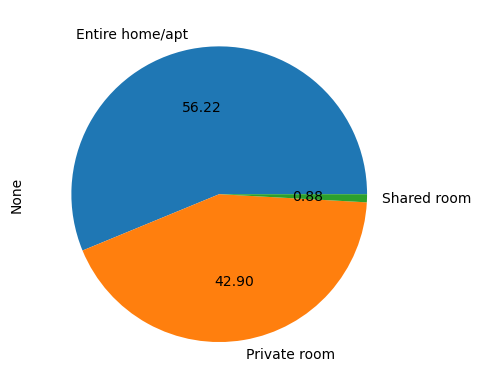

In [131]:
df_pd.groupby('room_type').size().plot(kind='pie', autopct='%.2f');

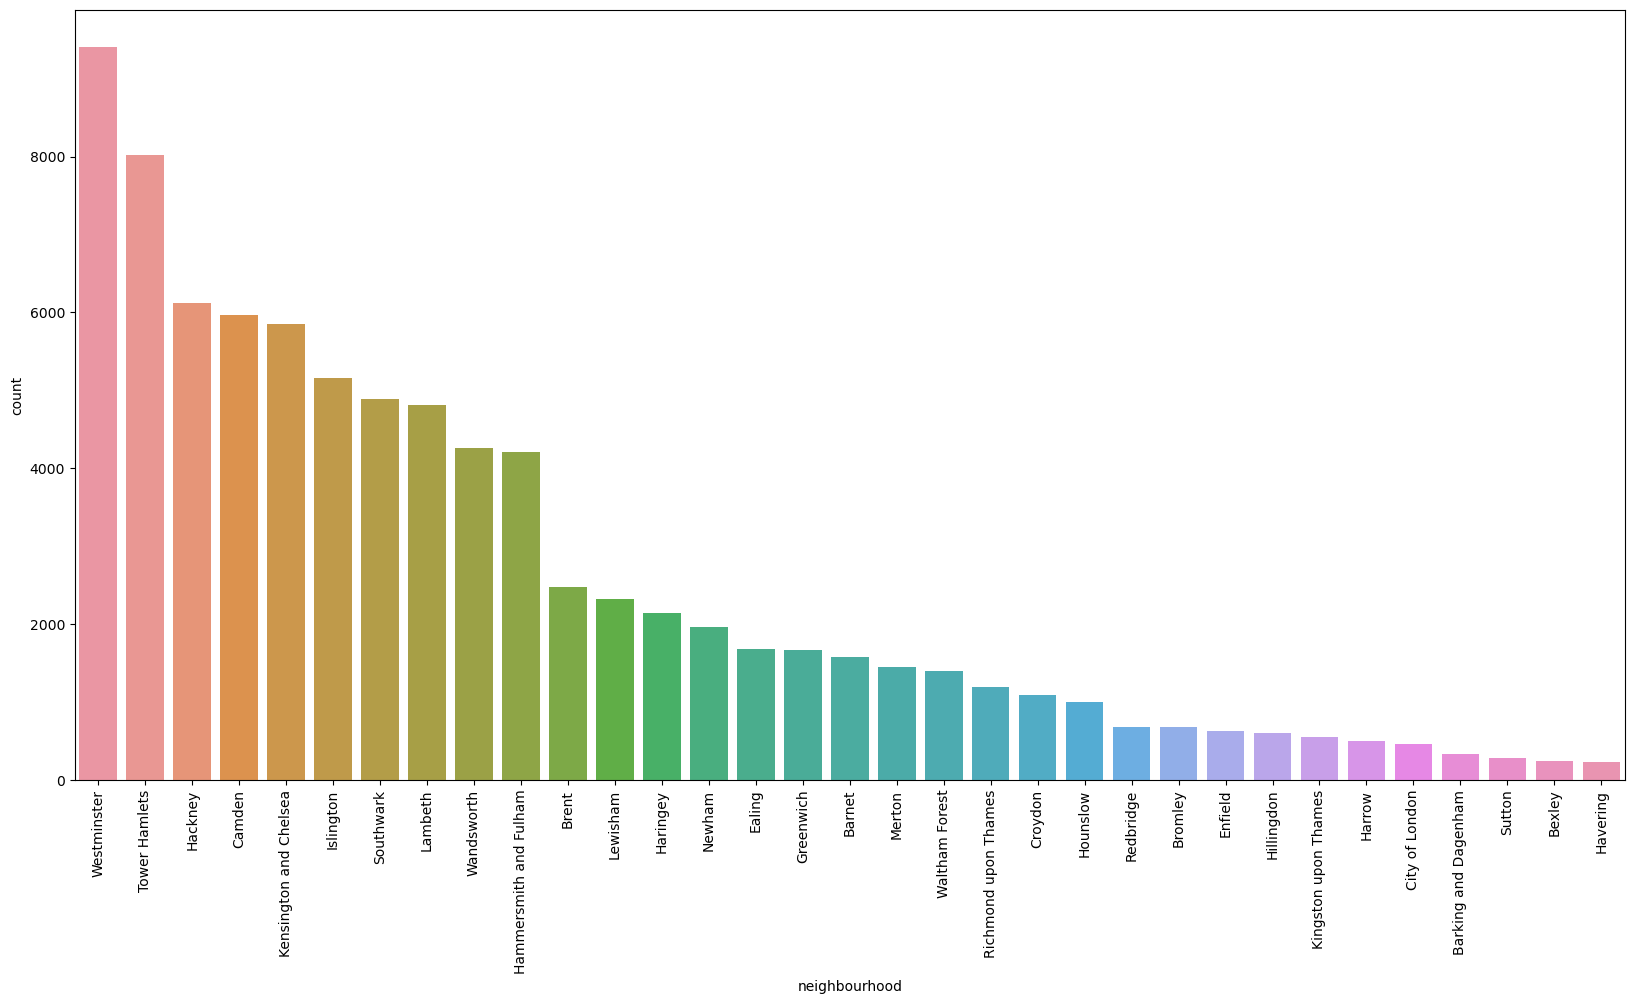

In [37]:
plt.figure(figsize=(20,10))
sns.countplot(x='neighbourhood', data=df_pd, order=df_pd['neighbourhood'].value_counts().index);
plt.xticks(rotation=90);

In [38]:
df_pd['neighbourhood'].value_counts()/df_pd.shape[0]

Westminster               0.112236
Tower Hamlets             0.095695
Hackney                   0.072940
Camden                    0.071175
Kensington and Chelsea    0.069791
Islington                 0.061491
Southwark                 0.058271
Lambeth                   0.057329
Wandsworth                0.050829
Hammersmith and Fulham    0.050197
Brent                     0.029481
Lewisham                  0.027704
Haringey                  0.025558
Newham                    0.023423
Ealing                    0.020036
Greenwich                 0.019857
Barnet                    0.018807
Merton                    0.017245
Waltham Forest            0.016613
Richmond upon Thames      0.014287
Croydon                   0.012940
Hounslow                  0.011986
Redbridge                 0.008181
Bromley                   0.008038
Enfield                   0.007549
Hillingdon                0.007239
Kingston upon Thames      0.006571
Harrow                    0.006035
City of London      

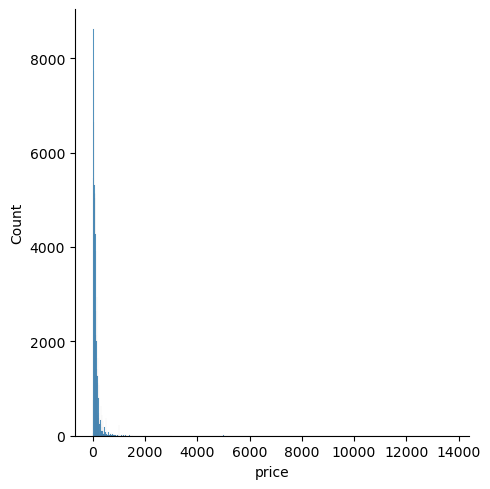

In [39]:
sns.displot(df_pd, x="price", binwidth=10);

In [40]:
import numpy as np

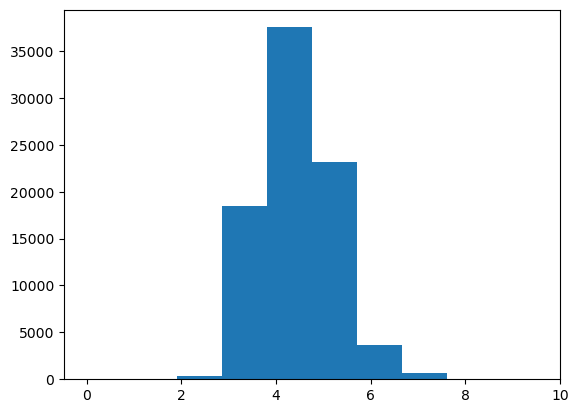

In [41]:
# this look much better distribution and closer to normal distribution
plt.hist(np.log(df_pd['price']+1));

In [132]:
df_merge = df_merge.withColumn("logPrice", log(col('price')+1))
df_merge.show(2)

+-----+-------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+-----------------+---------+--------------------+
|   id|host_id|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|Availability_365|last_review_date|host_listings_count|DaysSinceLastReview|listing_id|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12|         logPrice|minNightP|host_listings_countP|
+-----+-------+--------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+-----------------+------

In [133]:
import numpy as np
df_pd['log_price'] = np.log(df_pd["price"]+1)
df_pd.head(2)

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,...,8,9,10,11,12,_c0,id,Postcode,OtherPropertiesinPostcode,log_price
0,1000127,Southwark,51.48638,-0.10696,Entire home/apt,107.0,5,10,0.13,1,...,1.0,0.0,0.0,0.0,1.0,2116,1000127,SE17 3UT,19,4.682131
1,10005666,Camden,51.52,-0.11662,Entire home/apt,185.0,3,51,1.20,31,...,2.0,5.0,3.0,4.0,1.0,15181,10005666,WC1R 4BH,2,5.225747


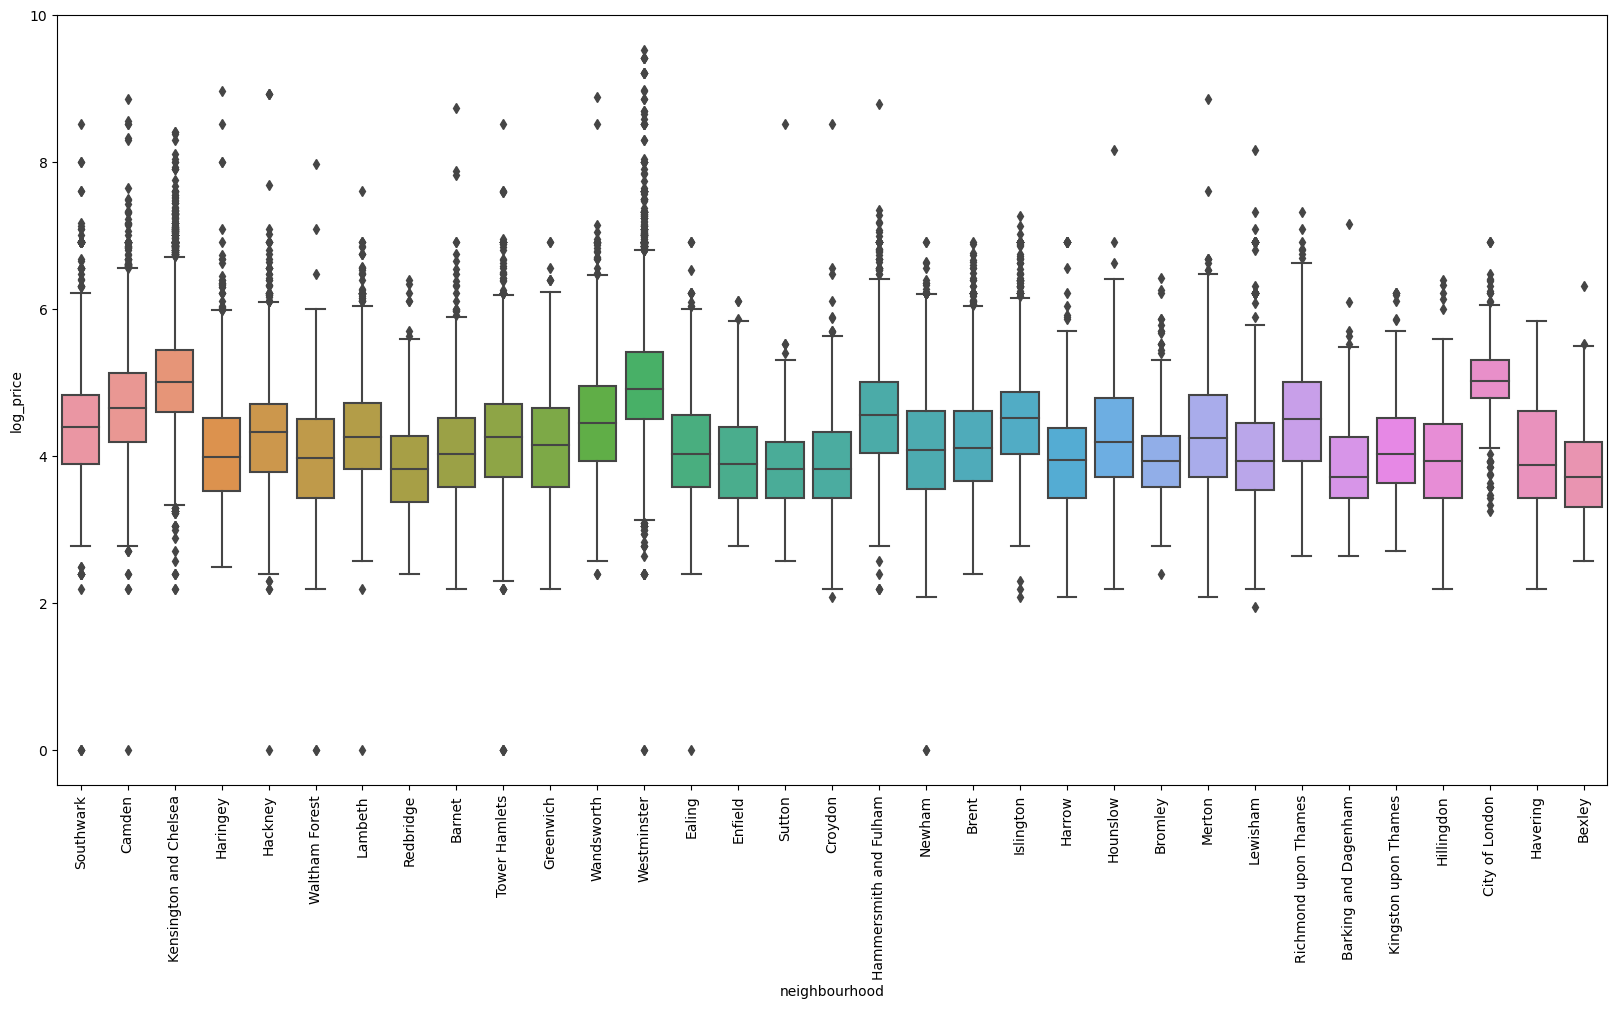

In [44]:
plt.figure(figsize=(20,10))
sns.boxplot(x='neighbourhood',y = "log_price", data=df_pd);
plt.xticks(rotation=90);

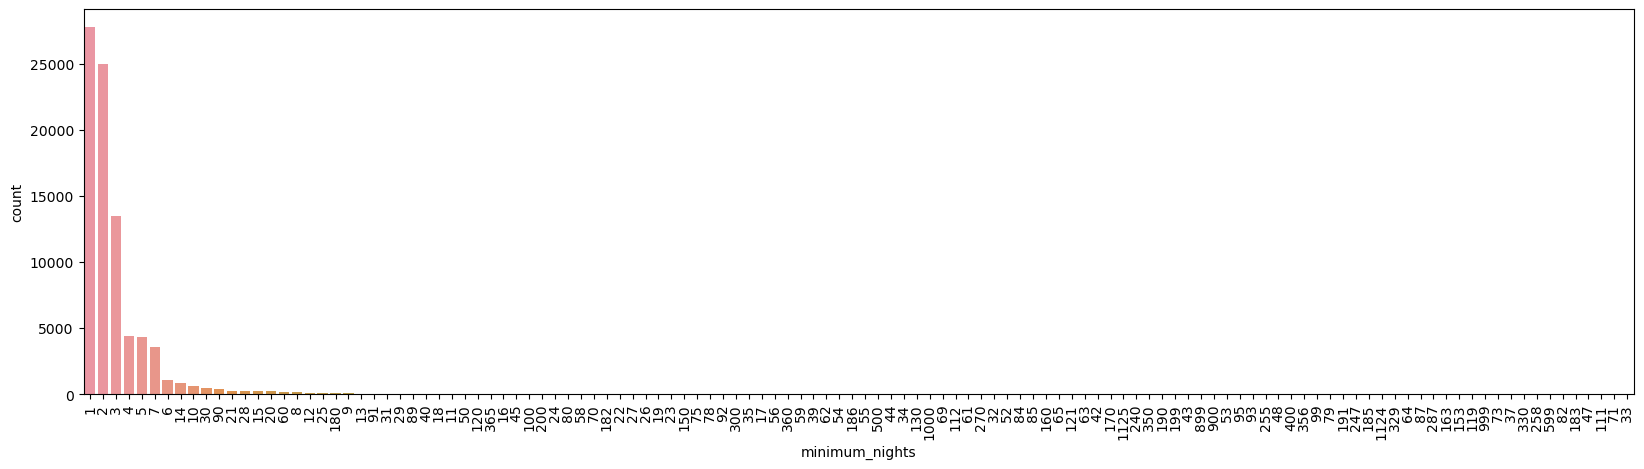

In [45]:
plt.figure(figsize=(20,5))
sns.countplot(x='minimum_nights', data=df_pd, order=df_pd['minimum_nights'].value_counts().index);
plt.xticks(rotation=90);


In [46]:
df_pd['minimum_nights'].value_counts()/df_pd.shape[0]

1      0.330972
2      0.297651
3      0.160704
4      0.052379
5      0.051843
         ...   
183    0.000012
47     0.000012
111    0.000012
71     0.000012
33     0.000012
Name: minimum_nights, Length: 120, dtype: float64

In [134]:
min_nightq = df_merge.approxQuantile("minimum_nights",[0.01,.95],0)
df_merge = df_merge.withColumn("minNightP", when(col("minimum_nights")> lit(min_nightq[1]), \
                                                   min_nightq[1]).otherwise(col("minimum_nights")))


#df_merge.show(2)

In [135]:
ninetyfive_percentile = np.percentile(df_pd["minimum_nights"], 95)

df_pd.loc[df_pd["minimum_nights"]>ninetyfive_percentile, "minimum_nights"] = ninetyfive_percentile

In [136]:
df_pd["minimum_nights"].value_counts()

1    27752
2    24958
3    13475
4     4392
5     4347
8     4287
7     3585
6     1054
Name: minimum_nights, dtype: int64

In [49]:
df_pd['number_of_reviews'].value_counts()/df_pd.shape[0]

0      0.250733
1      0.107621
2      0.069088
3      0.053834
4      0.041872
         ...   
422    0.000012
480    0.000012
286    0.000012
485    0.000012
579    0.000012
Name: number_of_reviews, Length: 394, dtype: float64

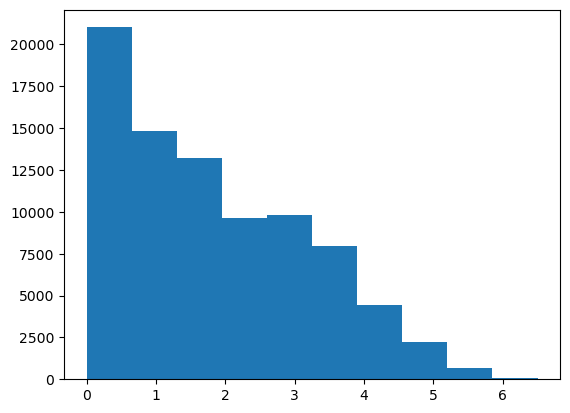

In [51]:
plt.hist(np.log(df_pd['number_of_reviews']+1));

In [137]:
df_merge = df_merge.withColumn("number_of_reviews", log(col('number_of_reviews')+1))
df_merge.show(2)

+-----+-------+--------------------+--------+---------+---------------+-----+--------------+------------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+-----------------+---------+--------------------+
|   id|host_id|       neighbourhood|latitude|longitude|      room_type|price|minimum_nights| number_of_reviews|reviews_per_month|calculated_host_listings_count|Availability_365|last_review_date|host_listings_count|DaysSinceLastReview|listing_id|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12|         logPrice|minNightP|host_listings_countP|
+-----+-------+--------------------+--------+---------+---------------+-----+--------------+------------------+-----------------+------------------------------+----------------+----------------+-------------------+-------------------+----------+---+---+---+---+---+---+---+---+---+---+---+---+-----------------+---

In [138]:
df_pd['number_of_reviews_log'] = np.log(df_pd['number_of_reviews']+1)


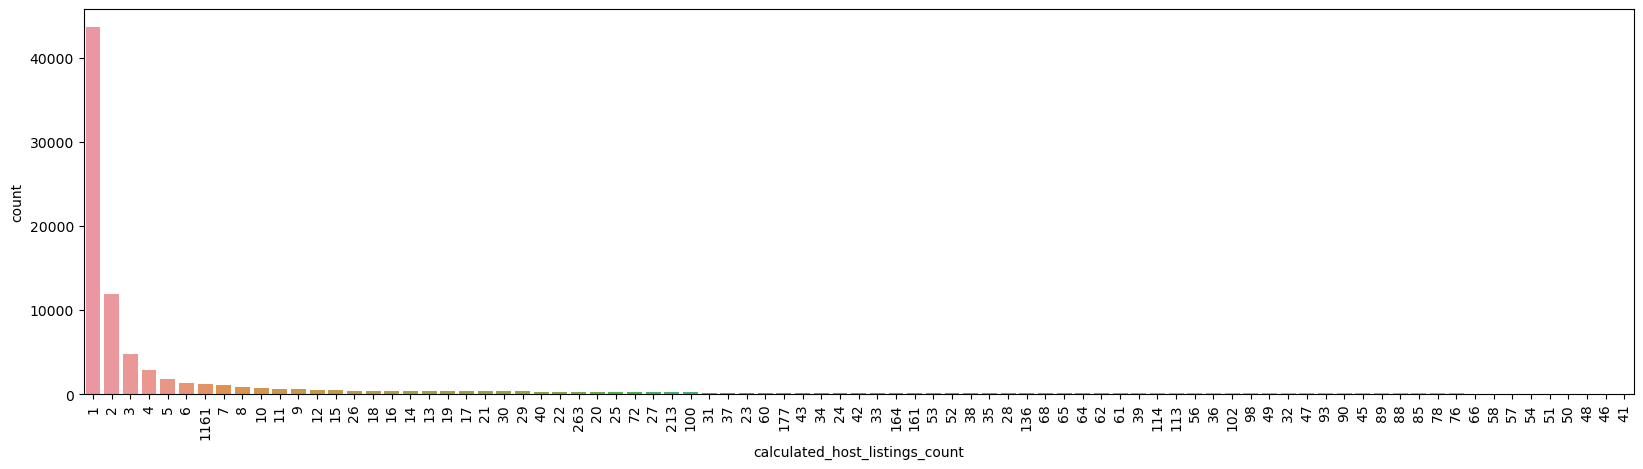

In [54]:
plt.figure(figsize=(20,5))
sns.countplot(x='calculated_host_listings_count', data=df_pd, order=df_pd['calculated_host_listings_count'].value_counts().index);
plt.xticks(rotation=90);

In [139]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
df_pd["DaysSinceLastReview"] = scaler.fit_transform(df_pd[["DaysSinceLastReview"]])

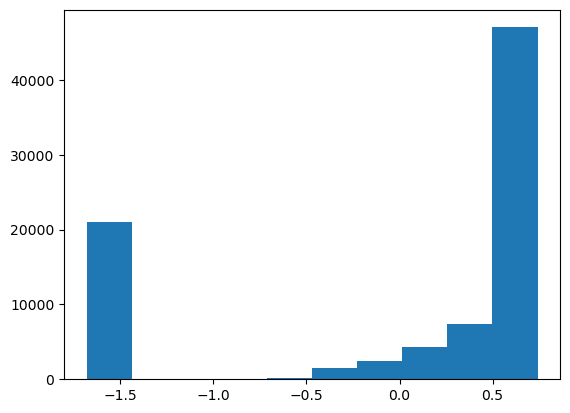

In [77]:
plt.hist(df_pd['DaysSinceLastReview']);

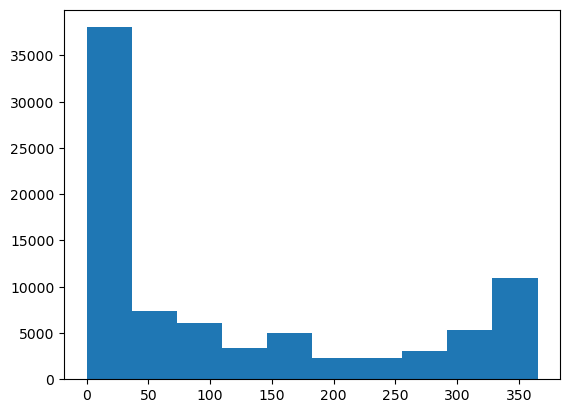

In [80]:
plt.hist(df_pd['Availability_365']);

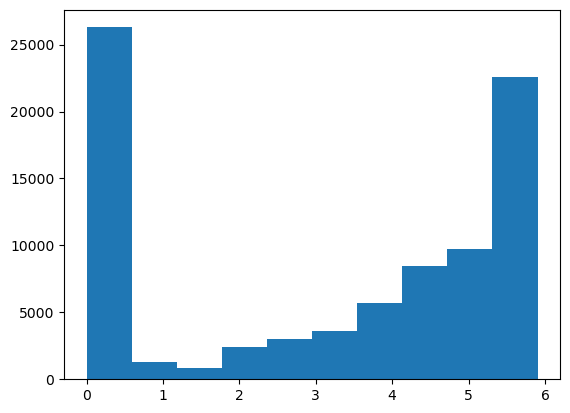

In [83]:
plt.hist(np.log(df_pd['Availability_365']+1));

In [140]:
df_pd["Availability_365_log"] = np.log(df_pd["Availability_365"]+1)

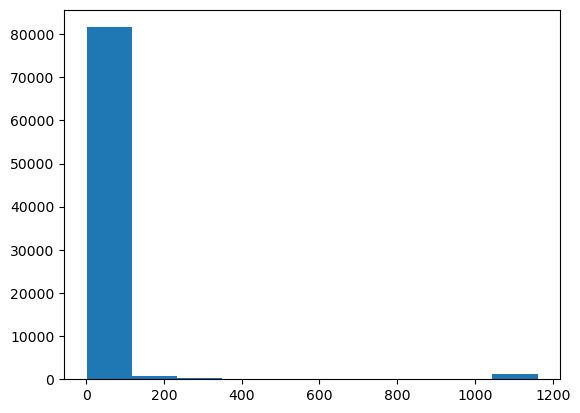

In [90]:
plt.hist(df_pd['host_listings_count']);

In [141]:
host_listings_countq = df_merge.approxQuantile("host_listings_count",[0.01,.95],0)
df_merge = df_merge.withColumn("host_listings_countP", when(col("host_listings_count")> lit(host_listings_countq[1]), \
                                                   host_listings_countq[1]).otherwise(col("host_listings_count")))


#df_merge.show(2)

In [142]:
ninetyfive_percentile = np.percentile(df_pd["host_listings_count"], 95)

df_pd.loc[df_pd["host_listings_count"]>ninetyfive_percentile, "host_listings_count"] = ninetyfive_percentile

In [57]:
#range(df_merge["Availability_365"])
df_pd['Availability_365'].value_counts()/df_pd.shape[0]

0      0.313608
365    0.023280
364    0.011532
1      0.009338
89     0.007573
         ...   
185    0.000489
250    0.000429
230    0.000429
206    0.000405
183    0.000394
Name: Availability_365, Length: 366, dtype: float64

In [143]:
df_pd.fillna(0, inplace=True)

In [144]:
df_pd.head(2)

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,...,10,11,12,_c0,id,Postcode,OtherPropertiesinPostcode,log_price,number_of_reviews_log,Availability_365_log
0,1000127,Southwark,51.48638,-0.10696,Entire home/apt,107.0,5,10,0.13,1,...,0.0,0.0,1.0,2116,1000127,SE17 3UT,19,4.682131,2.397895,5.257495
1,10005666,Camden,51.52,-0.11662,Entire home/apt,185.0,3,51,1.20,31,...,3.0,4.0,1.0,15181,10005666,WC1R 4BH,2,5.225747,3.951244,5.521461


In [154]:
df_pd["OtherPropertiesinPostcode"]= df_pd["OtherPropertiesinPostcode"].astype("int")

In [156]:
df_pdcor = df_pd[["minimum_nights","number_of_reviews_log","reviews_per_month","Availability_365_log","host_listings_count","DaysSinceLastReview","OtherPropertiesinPostcode","log_price"]]
df_pdcor.corr()


,minimum_nights,number_of_reviews_log,reviews_per_month,Availability_365_log,host_listings_count,DaysSinceLastReview,OtherPropertiesinPostcode,log_price
minimum_nights,1.000000,-0.160286,-0.224846,-0.026226,0.029514,-0.123924,0.002270,0.100586
number_of_reviews_log,-0.160286,1.000000,0.629847,0.186966,-0.074797,0.731431,0.039276,-0.119302
reviews_per_month,-0.224846,0.629847,1.000000,0.217600,-0.024462,0.471417,0.040796,-0.107879
Availability_365_log,-0.026226,0.186966,0.217600,1.000000,0.137573,0.158129,0.018521,0.130846
host_listings_count,0.029514,-0.074797,-0.024462,0.137573,1.000000,-0.053411,0.127766,0.313693
DaysSinceLastReview,-0.123924,0.731431,0.471417,0.158129,-0.053411,1.000000,0.026355,-0.088104
OtherPropertiesinPostcode,0.002270,0.039276,0.040796,0.018521,0.127766,0.026355,1.000000,0.130784
log_price,0.100586,-0.119302,-0.107879,0.130846,0.313693,-0.088104,0.130784,1.000000


<AxesSubplot:>

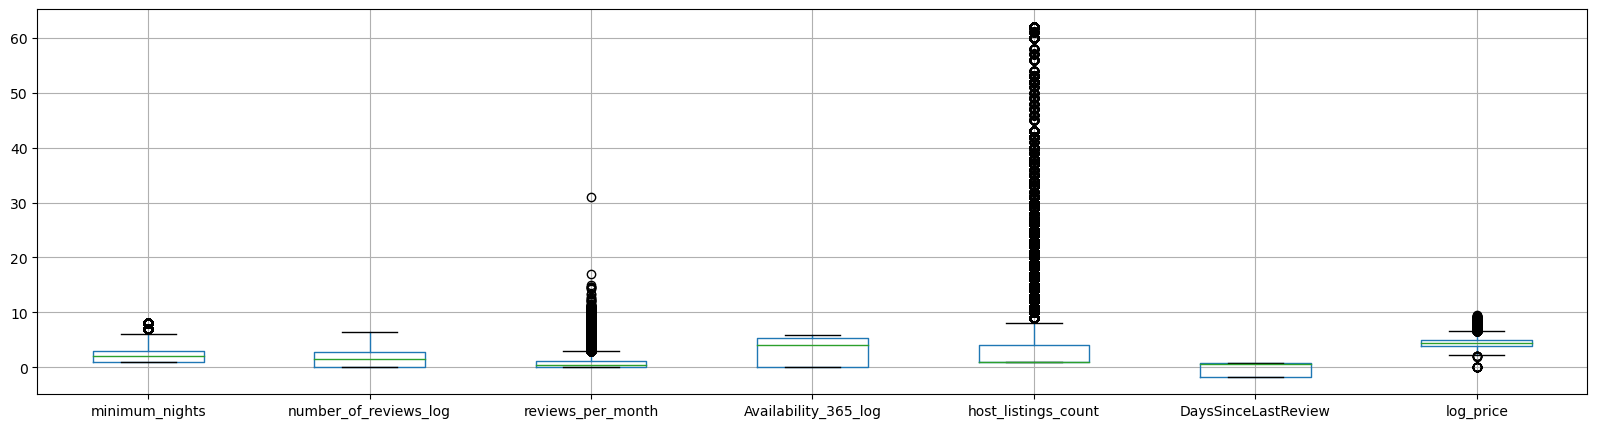

In [101]:
plt.figure(figsize=(20,5))

df_pdcor.boxplot()

In [161]:
df_pd = df_pd.drop(["id","_c0","Postcode"], axis=1)

In [163]:
df_pd.to_csv("airBnb_final2.csv")

In [162]:
df_pd.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,Availability_365,...,7,8,9,10,11,12,OtherPropertiesinPostcode,log_price,number_of_reviews_log,Availability_365_log
0,Southwark,51.48638,-0.10696,Entire home/apt,107.0,5,10,0.13,1,191,...,2.0,1.0,0.0,0.0,0.0,1.0,19,4.682131,2.397895,5.257495
1,Camden,51.52,-0.11662,Entire home/apt,185.0,3,51,1.20,31,249,...,1.0,2.0,5.0,3.0,4.0,1.0,2,5.225747,3.951244,5.521461
2,Kensington and Chelsea,51.49266,-0.19971,Entire home/apt,250.0,2,40,0.96,1,21,...,3.0,1.0,4.0,6.0,2.0,3.0,7,5.525453,3.713572,3.091042
3,Haringey,51.57828,-0.09101,Private room,140.0,3,0,0.00,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4.948760,0.000000,0.000000
4,Hackney,51.53636,-0.06705,Entire home/apt,120.0,3,0,0.00,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,19,4.795791,0.000000,1.386294


In [164]:
new_df = spark.read.csv("C:/Users/ankus/Downloads/IIT J/Big Data Management/PGD22DC004Assgn2/airBnb_final2.csv",\
                    header = True, inferSchema= True)
new_df.show(2)

+---+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+-------------------+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+-------------------------+-----------------+---------------------+--------------------+
|_c0|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|Availability_365|host_listings_count|DaysSinceLastReview|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12|OtherPropertiesinPostcode|        log_price|number_of_reviews_log|Availability_365_log|
+---+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+-------------------+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+-------------------------+-----------------+---------------------+-----------------

In [165]:
new_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- Availability_365: integer (nullable = true)
 |-- host_listings_count: integer (nullable = true)
 |-- DaysSinceLastReview: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = t

In [166]:
new_df = new_df.drop("_c0","latitude","longitude","price","Availability_365","number_of_reviews","calculated_host_listings_count")
new_df.count()

83850

In [167]:
new_df.printSchema()

root
 |-- neighbourhood: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- host_listings_count: integer (nullable = true)
 |-- DaysSinceLastReview: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- OtherPropertiesinPostcode: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- number_of_reviews_log: double (nullable = true)
 |-- Availability_365_log: double (nullable = true)



In [168]:
## [Categorical and Numerical column] ##

# See how many categorical + numerical features:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')]

print(str(len(cat_cols)) + '  categorical features')
print(str(len(num_cols)) + '  numerical features')

2  categorical features
20  numerical features


In [169]:
num_cols.remove("log_price")
num_cols

['minimum_nights',
 'reviews_per_month',
 'host_listings_count',
 'DaysSinceLastReview',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 'OtherPropertiesinPostcode',
 'number_of_reviews_log',
 'Availability_365_log']

In [170]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert #aech v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot ector #and the rest of numerical features into a 
# single vector column. we append every step of the process in a #stages array
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [171]:
from pyspark.ml import Pipeline
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)

In [180]:
# split the data into trainign and testin sets
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())


67239
16611


In [181]:
from pyspark.ml.regression import LinearRegression
LR=LinearRegression(featuresCol='features',labelCol='log_price')
#pass train_data to train model
LR_model=LR.fit(train)
#evaluating model trained for Rsquared error
LR_results=LR_model.evaluate(train)
  
print('Rsquared Error :',LR_results.r2)
print('rmse Error :',LR_results.rootMeanSquaredError)
print('Adj Rsquared Error :',LR_results.r2adj)

# LR = LinearRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
# LR_model = LR.fit(train)

Rsquared Error : 0.5516111783566758
rmse Error : 0.5225288015820326
Adj Rsquared Error : 0.5512574594082931


In [182]:
LR_results_test=LR_model.evaluate(test)
  
print('Rsquared Error :',LR_results_test.r2)
print('rmse Error :',LR_results_test.rootMeanSquaredError)
print('Adj Rsquared Error :',LR_results_test.r2adj)

Rsquared Error : 0.5531413690487219
rmse Error : 0.5210006874853567
Adj Rsquared Error : 0.5517109464214092


In [185]:
# split the data into trainign and testin sets for RF
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

67239
16611


In [190]:
# first we check how LogisticRegression perform 
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


rf = RandomForestRegressor(featuresCol='features',labelCol='log_price')
rfevaluator = RegressionEvaluator(labelCol="log_price", metricName="r2")
rfevaluator2 = RegressionEvaluator(labelCol="log_price", metricName="rmse")



rf_model = rf.fit(train)

# # Use test set here so we can measure the accuracy of our model on new data
rfpredictions_train = rf_model.transform(train)
pred = rf_model.transform(test)


print('R-square:', rfevaluator.evaluate(rfpredictions_train))
print('RMSE:', rfevaluator2.evaluate(rfpredictions_train))

R-square: 0.5413703047025435
RMSE: 0.5284622025681247


In [191]:
rfpredictions_test = rf_model.transform(test)

print('R-square:', rfevaluator.evaluate(rfpredictions_test))
print('RMSE:', rfevaluator2.evaluate(rfpredictions_test))

R-square: 0.5429902074919013
RMSE: 0.5268851690032376
